In [3]:
setwd('C:/Users/bki19/Desktop/anomaly_detection_twitter')

트위터 이상치 탐지 (anomaly detection) 알고리즘을 공부한 내용입니다.<br>
논문을 공부하면서 STL-H-ESD 알고리즘을 쉽게 이해할 수 있도록 코드와 예제를 통해 주석을 달았습니다.<br>
<br>
출처:
- Hochenbaum, J., Vallis, O. S., & Kejariwal, A. (2017). Automatic anomaly detection in the cloud via statistical learning. arXiv preprint arXiv:1704.07706.<br>
- https://github.com/twitter/AnomalyDetection/tree/master/R

# 2.1.1 Grubbs Test

<b>Grubbs Test</b>
- 일변량 데이터에서 가장 큰 이상치를 찾는 방법
- 데이터의 분포가 Normal이라고 가정
<br>
$𝐻_0$:데이터 속에 이상치가 하나도 없다<br>
$𝐻_1$:이상치가 최소한 하나는 있다<br>
<br>
양측 검정: $C >\lambda $ => $𝐻_0$ 기각 : 이상치가 최소한 하나는 있다<br>
Test Statistic: $C=\frac{max_{t} |x_{𝑡}−\bar{x}|  }{s}$<br>
Critical Value: $\lambda=\frac{(N-1)}{\sqrt{N}} \sqrt{ \frac{t^{2}_{p,N-2}}{N-2+t^{2}_{p,N-2}}  }$
여기서 $ p=\frac{\alpha}{2N}$<br>
<br>
단측검정:<br>
최대값 찾을 때: $C= \frac{max_{t}(x_{t})-\bar{x}}{s}$ <br>
최소값 찾을 때: $C= \frac{\bar{x}-min_{t}(x_{t})}{s}$<br>
여기서 $ p=\frac{\alpha}{N}$<br>

- 장점: 최대 값이 이상치인지 혹은 최소값이 이상치인지 알 수 있음
- 단점: 이상치가 여러 개인 경우 적합하지 않음

<b>예제 데이터</b><br>
출처:
- Tietjen and Moore (August 1972), Some Grubbs-Type Statistics for the Detection of Outliers, Technometrics, 14(3), pp. 583-597.<br>
- https://www.itl.nist.gov/div898/handbook/eda/section4/eda43.htm#Tietjen  <br>

In [4]:
set.seed(0)
A=c(199.31, 199.53, 200.19, 200.82, 201.92, 201.95, 202.18, 245.57)
B= c(rnorm(20,0,1),c(100), rnorm(20,0,1),c(111) ) 

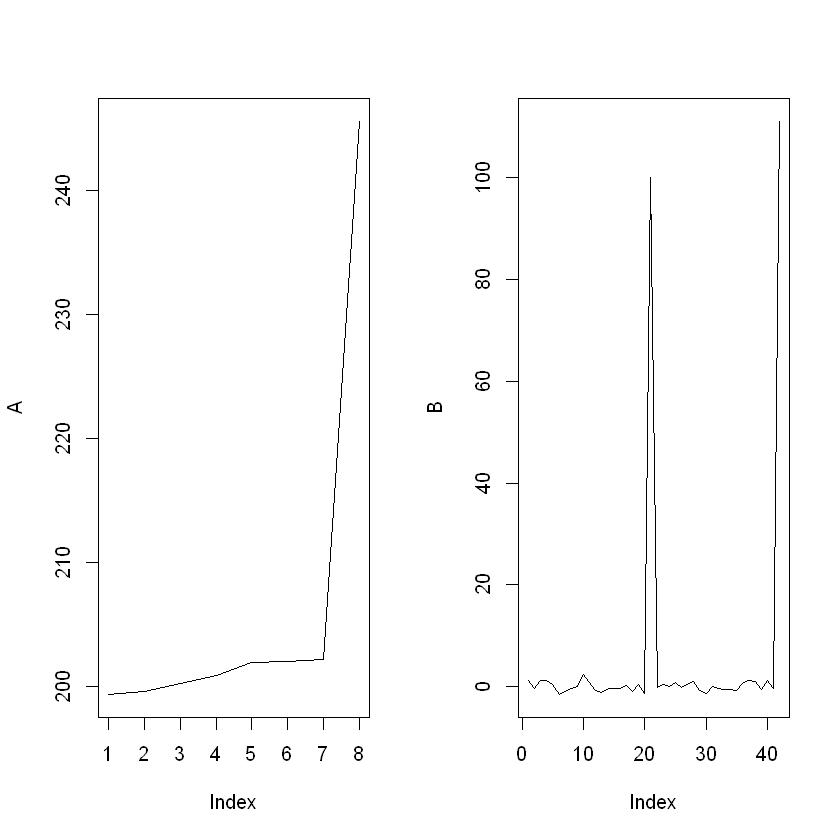

In [5]:
par(mfrow=c(1,2))
plot(A,type='l')
plot(B,type='l')

A는 Tietjen and Moore의 논문의 데이터로 8번 데이터가 Outlier입니다.<br>
B는 정규분포에서 임의로 생성하고 두 개의 Outlier를 중간에 집어 넣었습니다.<br>
Grubb's Test가 두 데이터에서 Outlier를 찾을 수 있는지 실험했습니다.

In [6]:
#Onesided, data, alpha, Max or min
Grubb<-function(Onesided=TRUE,A,alpha=0.05,MAX=TRUE){
    #two-sided
    if (Onesided==FALSE){
        C=abs( max(A)-mean(A))/sd(A) #test statistic
        I=which.max(A)
        N=length(A)
        p=alpha/(2*N)
        t=qt(p ,N-2  )
        T=((N-1)/sqrt(N)  )*sqrt( (t^2)/(N-2+t^2)) # critical value
        
        #reject Null==At least one Abnomalies
        if (C>T) {
            return(which.max( A))
            
        }
        else{
            print('No Outlier')
        }
    }
    
        #one-sided
    else {
        if(MAX==TRUE){
            C=( max(A)-mean(A))/sd(A) #test statistic
            I=which.max(A)
            N=length(A)
            p=alpha/(N)
            t=qt(p ,N-2  )
            T=((N-1)/sqrt(N)  )*sqrt( (t^2)/(N-2+t^2)) # critical value
                if (C>T) {
                    return(which.max( A))
            
                    }
                else{
                    print('No Outlier')
                    }

            }
        else{
            C=( mean(A)-min(A))/sd(A) #test statistic
            I=which.max(A)
            N=length(A)
            p=alpha/(N)
            t=qt(p ,N-2  )
            T=((N-1)/sqrt(N)  )*sqrt( (t^2)/(N-2+t^2)) # critical value
                if (C>T) {
                    return(which.max( A))
            
                    }
                else{
                    print('No Outlier')
                    }

            
            
            }

        }

        
               
}

In [7]:
G1=Grubb(FALSE,A,alpha=0.05,FALSE)
G11=Grubb(FALSE,B,alpha=0.05,FALSE)

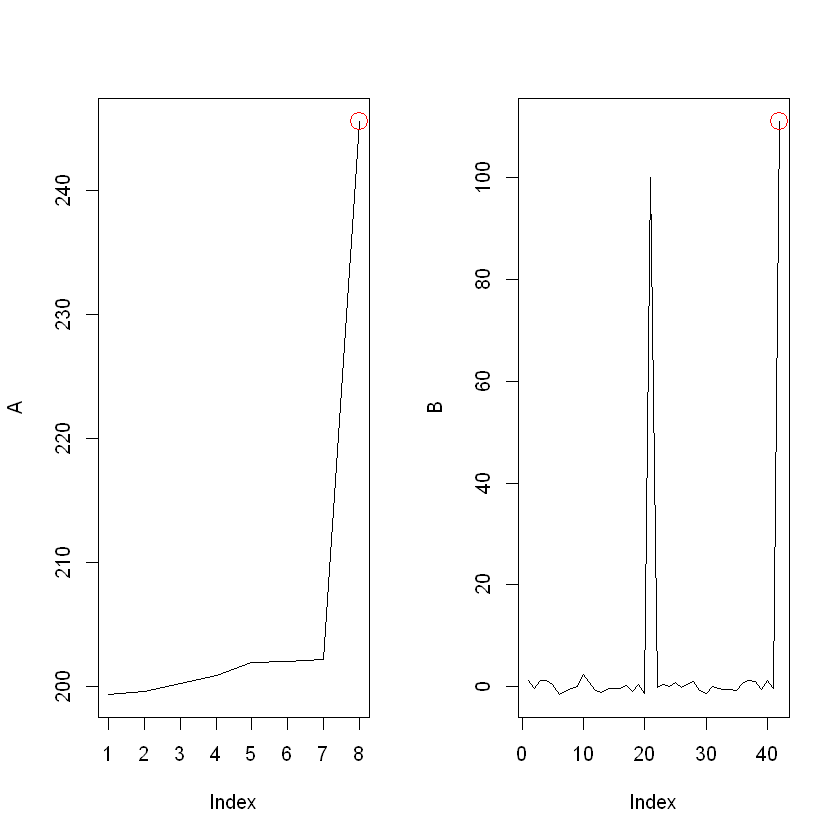

In [8]:
par(mfrow=c(1,2))
plot(A,type='l')
points(G1,A[G1],col='red',cex=2)
plot(B,type='l')
points(G11,B[G11],col='red',cex=2)

Grubb's test로 두 데이터에서 빨간색으로 표시 된 anomaly를 찾는데 성공했습니다.<br>
하지만 데이터 B를 봤을 때 두 개의 Outlier 중 가장 큰 Outlier만 찾은 것을 볼 수 있습니다.<br>
이것은 Grubb's test가 Global anomaly를 찾는 검정 방법이기 때문입니다.

# 2.1.2 ESD

ESD(Extreme Studentized Deviate Test)
- Grubbs test나 TietjenMoore test는 이상치의 개수를 미리 정확하게 설정해야 한다는 한계가 있음
- 이에 반해 ESD는 여러 개의 이상치를 찾을 수 있고 의심되는 이상치의 개 수의 상한만 있으면 됨
- 상한이 주어지면 의심되는 이상치의 개수 k개에서 k=1,2.,,,k에 대해서 순차적으로 k번 이상치를 찾음 <br>
$𝐻_0$:데이터 속에 이상치가 하나도 없다<br>
$𝐻_1$:이상치가 K개까지 있다<br>
<br>
양측검정:<br>
Critical Value: $C_{k}=\frac{max_{k} |x_{k}-\bar{x}|}{s}$<br>
Test Statictic: $\lambda_{k}=\frac{(n-k)t_{p,n-k-1}} {\sqrt{(n-k+1+t^{2}_{p,n-k-1})(n-k+1) }}$<br>
$p=1-\frac{\alpha}{2(n-k+1)}$<br>
<br>
단측 검정:<br>
최대 값을 찾을 때: $C_{k}=\frac{max_{k} (x_{k}-\bar{x})}{s}$<br>
최소 값을 찾을 때: $C_{k}=\frac{max_{k} (\bar{x}-x_{k})}{s}$<br>
$p=1-\frac{\alpha}{(n-k+1)}$<br>


Psudo Code<br>
for k in 1:K<br>
    if Test $C_{k=1}> \lambda_{k=1}$
    reject $H_{0}$ => Outlier k개 있다<br>
    $\frac{|x_{t}-\bar{x}|}{s} $을 최대화하는 데이터 t 제거 후 테스트 진행<br>
       

아래에서 예제를 통해 테스트 방법을 소개하겠습니다.


$C_{k}>\lambda_{k}$ 인 이상치의 수가 가장 큰  𝑘 가 되도록 𝑘 번 반복 <br>
- 실제 적용하면 $C_{k}$가 $\lambda_{k}$ 보다 커졌다가 작아졌다가 반복 하다가 나중에는 $\lambda_{k}$ 보다 계속 작아짐 
- 예상되는 이상치의 개수에 따라 critical value를 적절하게 조절한다는 장점
- 심각한 masking이 있으면 멈춰버림
- 양측 검정 밖에 안됨 (but Twitter에서는 단측 검정도 구현)

출처:
- Rosner, Bernard (May 1983), Percentage Points for a Generalized ESD Many-Outlier Procedure,Technometrics, 25(2), pp. 165-172.
- https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm

In [13]:
C<-read.csv('./data/anomaly.csv',head=FALSE)
C<-C[,1]

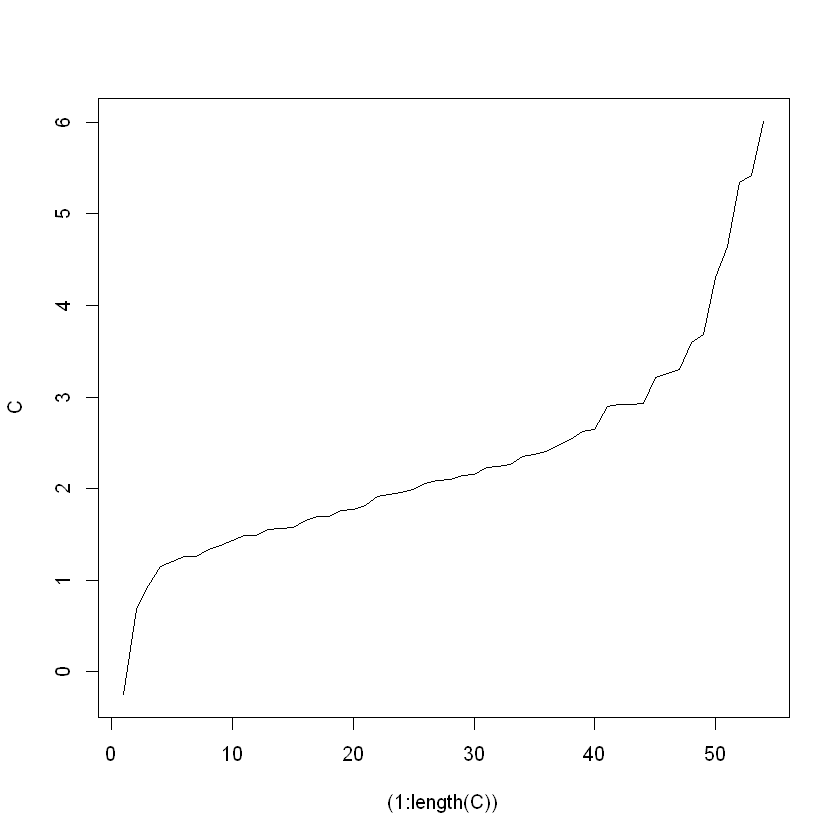

In [14]:
plot(( 1:length(C) ),C,type='l')

In [15]:
ESD<-function(data,alpha=0.05,max_outliers,one_tail=FALSE,upper_tail=TRUE){
    
    n=length(data)
    alpha=0.05
    outlier_idx<-c()
    
    for (i in 1L:max_outliers){

    
    if(one_tail){
        if(upper_tail){
            ares <- data - mean(data)
        } else {
            ares <- mean(data) - data
        }
    } else {
        ares = abs(data - mean(data))
    }
        
    ## Compute critical value.
    data_sigma <- sd(data)
    ares <- ares/data_sigma
    R <- max(ares)

    idx <- which.max(ares) #maximum value's index
    outlier_idx<-c(outlier_idx,idx)
    data <- data[- idx ] #remove maximum data

    ## Compute critical value.
    if(one_tail){
        p <- 1 - alpha/(n-i+1)
    } else {
        p <- 1 - alpha/(2*(n-i+1))
    }
    t <- qt(p,(n-i-1))
    lam <- t*(n-i) / sqrt((n-i-1+t**2)*(n-i+1))

    #When reject Null (There is Outlier)
    if(R > lam) {
        num_anoms <- i
        }
}

### Select maximum k satisfying condition

if(num_anoms > 0) {
    outlier_idx<-outlier_idx[1:num_anoms]
} else {
  outlier_idx<-NULL  
}
return (outlier_idx)    
}

In [16]:
ESD_B=ESD(B,0.05,10,one_tail=FALSE,upper_tail=FALSE)
ESD_C=ESD(C,0.05,10,one_tail=FALSE,upper_tail=FALSE)
ESD_B
ESD_C

[1] 42 21

[1] 54 53 52

위 데이터 C로 테스트 진행에 대한 예를 들겠습니다.<br>
아웃라이어는 10개 이하라고 생각하여 K=20으로 설정하고 테스트를 진행하겠습니다.<br>
k=1일 때 $\frac{|x_{t}-\bar{x}}{s}$을 최대화하는 데이터가 54번째 데이터였습니다. 이 때 54번째 데이터를 제거 후 Test statistic과 Critical value를 구하면 $C_{1}=3.118, \lambda_{1}=3.158$입니다.<br>
$C_{1}<\lambda_{1}$이기 때문에 $H_{0}$을 기각하지 못해 아웃라이어가 없다는 결론을 내리고 k=2로 진행합니다.<br>
<br>
k=2일 때 $\frac{|x_{t}-\bar{x}}{s}$을 최대화하는 데이터가 53번째 데이터였습니다.<br>
$C_{2}=2.942, \lambda_{2}=3.151$로 $C_{2}<\lambda_{2}$로 여전히 기각하지 못합니다.<br>
 하지만 k=3일 때 $C_{3}=3.179, \lambda_{3}=3.143$으로 $C_{2}>\lambda_{2}$이기 때문에 $H_{0}$을 기각하여 아웃라이어가 3개 있다는 결론에 도달합니다. <br>
 <br>
이후에 $k=4,...10$까지 계속 $C_{k}<\lambda_{k}$이기 때문에 Outlier는 3개라는 결론에 도달합니다.
<br>
만약에 이후의 $k$에서 $C_{k}>\lambda_{k}$ 인 경우가 있으면 가장 큰 $k$에 대한 결론을 수용합니다.

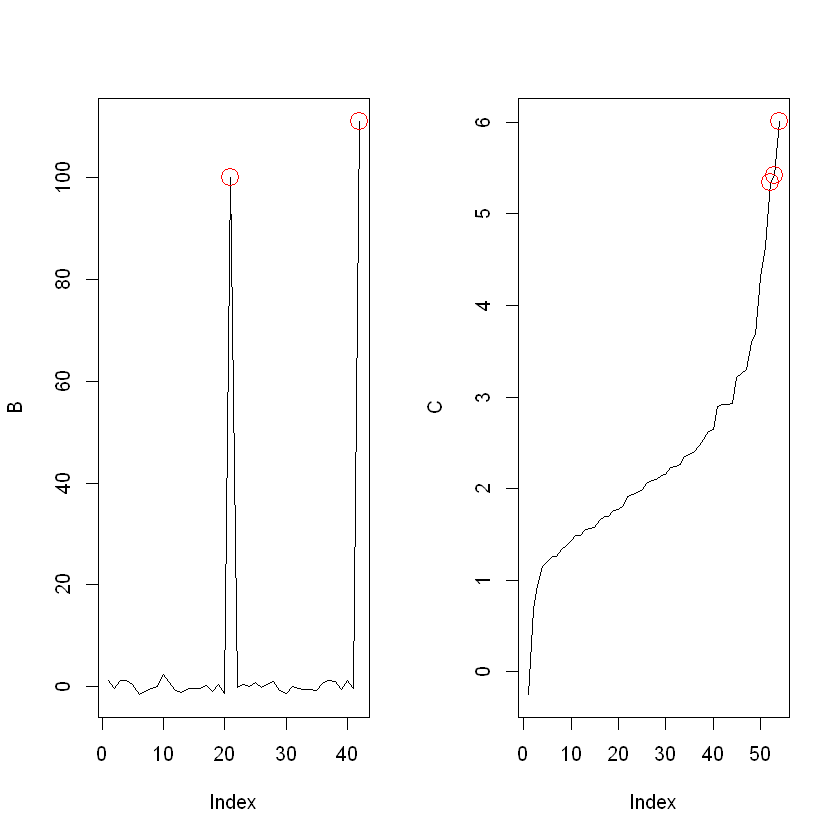

In [17]:
par(mfrow=c(1,2))
plot(B,type='l')
points(ESD_B,B[ESD_B],col='red',cex=2)
plot(C,type='l')
points(ESD_C,C[ESD_C],col='red',cex=2)

위 방법을 사용하였을 때 데이터 B에서 두 개의 outlier를 모두 찾게 됐음을 알 수 있습니다.

# 2.2 Median and MAD

하지만 평균과 표준편차는 Outlier에 민감하다는 문제가 있음
- Medain(중위수)은 Outlier에 더 robust하다는 장점<br>
$MAD=median_{i}(|X_{i}-median_{j}(X_{j}) |)$<br>
$\hat{\sigma}=b\cdot MAD$<br>
데이터가 Normal 분포를 따를때 b=1.4286<br>
Leyes 등은 Normal 분포가 아닐 때 $b=\frac{1}{Q(0.75)}$를 사용할 것을 제안 ($Q(0.75)$은 분포에서 0.75 quantile)

In [18]:
HESD<-function(data,alpha=0.05,max_outliers,one_tail=FALSE,upper_tail=TRUE){
    
    n=length(data)
    alpha=0.05
    outlier_idx<-c()
    
    for (i in 1L:max_outliers){

    
    if(one_tail){
        if(upper_tail){
            ares <- data - median(data)
        } else {
            ares <- median(data) - data
        }
    } else {
        ares = abs(data - median(data))
    }
        
    ## Compute critical value.
    data_sigma <- mad(data)
    ares <- ares/data_sigma
    R <- max(ares)

    idx <- which.max(ares) #maximum value's index
    outlier_idx<-c(outlier_idx,idx)
    data <- data[- idx ] #remove maximum data

    ## Compute critical value.
    if(one_tail){
        p <- 1 - alpha/(n-i+1)
    } else {
        p <- 1 - alpha/(2*(n-i+1))
    }
    t <- qt(p,(n-i-1))
    lam <- t*(n-i) / sqrt((n-i-1+t**2)*(n-i+1))

    #When reject Null (There is Outlier)
    if(R > lam) {
        num_anoms <- i
        }
}

### Select maximum k satisfying condition

if(num_anoms > 0) {
    outlier_idx<-outlier_idx[1:num_anoms]
} else {
  outlier_idx<-NULL  
}
return (outlier_idx)    
}

In [19]:
HESD_B=HESD(B,0.05,10,one_tail=FALSE,upper_tail=FALSE)
HESD_C=HESD(C,0.05,10,one_tail=FALSE,upper_tail=FALSE)
HESD_B
HESD_C

[1] 42 21

[1] 54 53 52 51

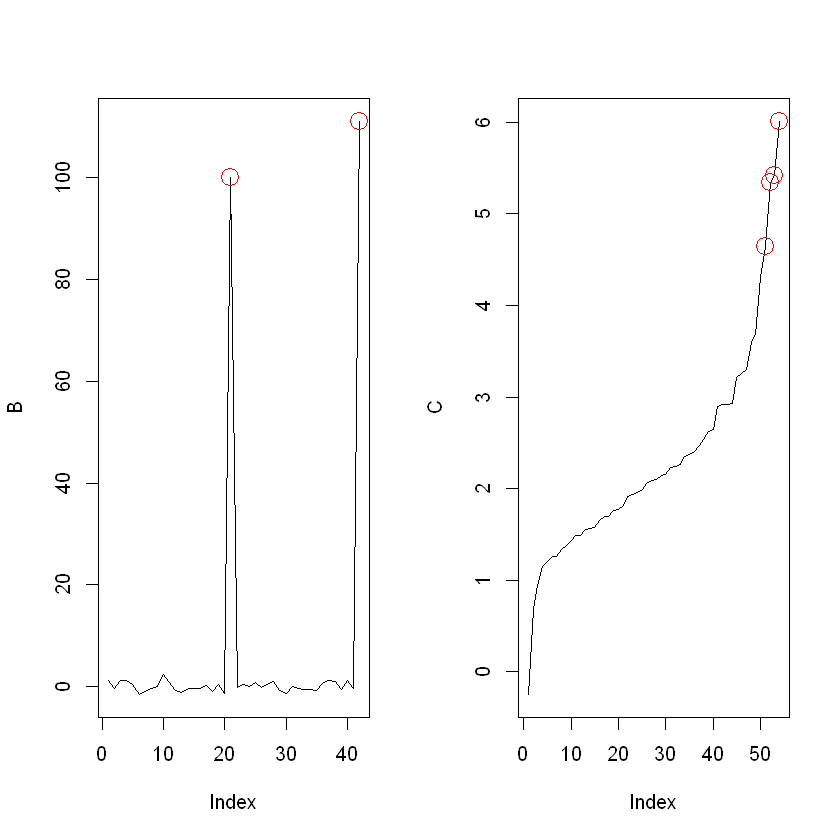

In [20]:
par(mfrow=c(1,2))
plot(B,type='l')
points(HESD_B,B[HESD_B],col='red',cex=2)
plot(C,type='l')
points(HESD_C,C[HESD_C],col='red',cex=2)

Median, MAD를 사용했을 때 B에서는 같은 이전과 같은 결과를 얻었지만 C에서는 데이터 하나를 더 outlier라고 진단했습니다

# 3.1 3-sigma rule

본론으로 들어가기 전에 흔하게 사용되는 3-sigma rule을 살펴보고 시계열 데이터에서의 anomaly detection의 어려움을 살펴보겠습니다.

데이터에서 표준편차의 3배 이상인 지점을 이상치로 판단 <br>
데이터가 Normal 분포를 따른 다는 가정 <br>
<br>
장점<br>
- 심플함
- Global anomaly 찾기 쉬움
<br>
단점
- 계절성 있는 데이터에 잘 안 맞음

In [21]:
load("./data/raw_data.rda") 

<b>데이터: 트위터 Production data<br></b>
- 1분 단위 데이터
- 하루 간격으로 계절성이 존재<br>
- 총 데이터 기간은 10일 가량

In [22]:
head(raw_data)

timestamp,count
1980-09-25 14:01:00,182.478
1980-09-25 14:02:00,176.231
1980-09-25 14:03:00,183.917
1980-09-25 14:04:00,177.798
1980-09-25 14:05:00,165.469
1980-09-25 14:06:00,181.878


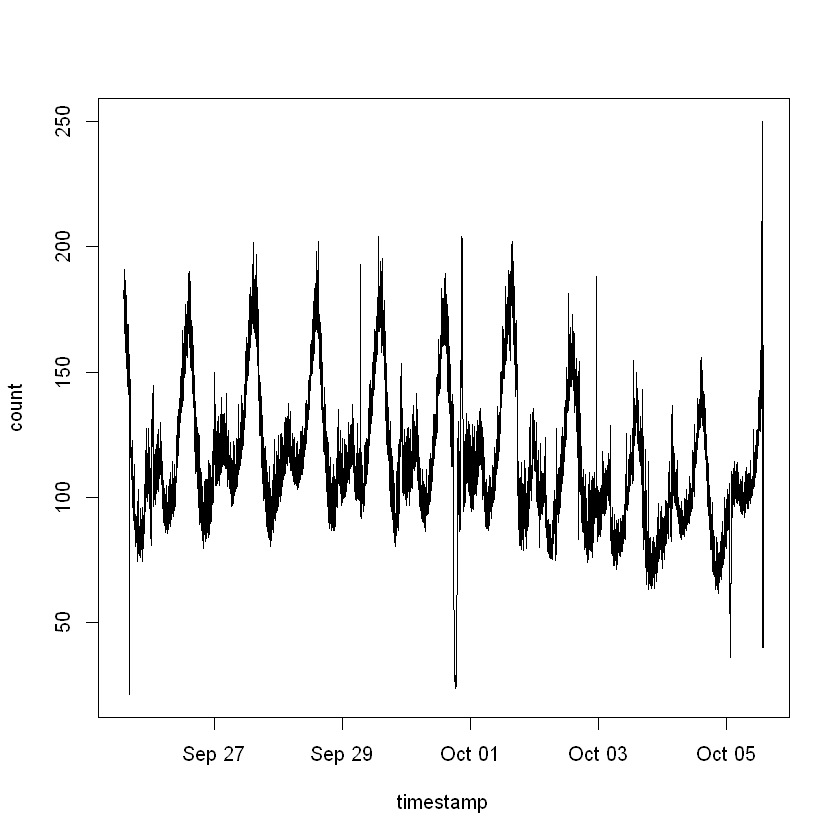

In [23]:
plot(raw_data,type='l')

저녁 시간에 피크를 찍고 하루가 넘어가는 지점에 확연히 떨어지다가 12시 부터 새벽 3시 가량까지 피크를 찍는 패턴이 반복<br>
- 하루마다 반복 되는 패턴 존재 (계절성)

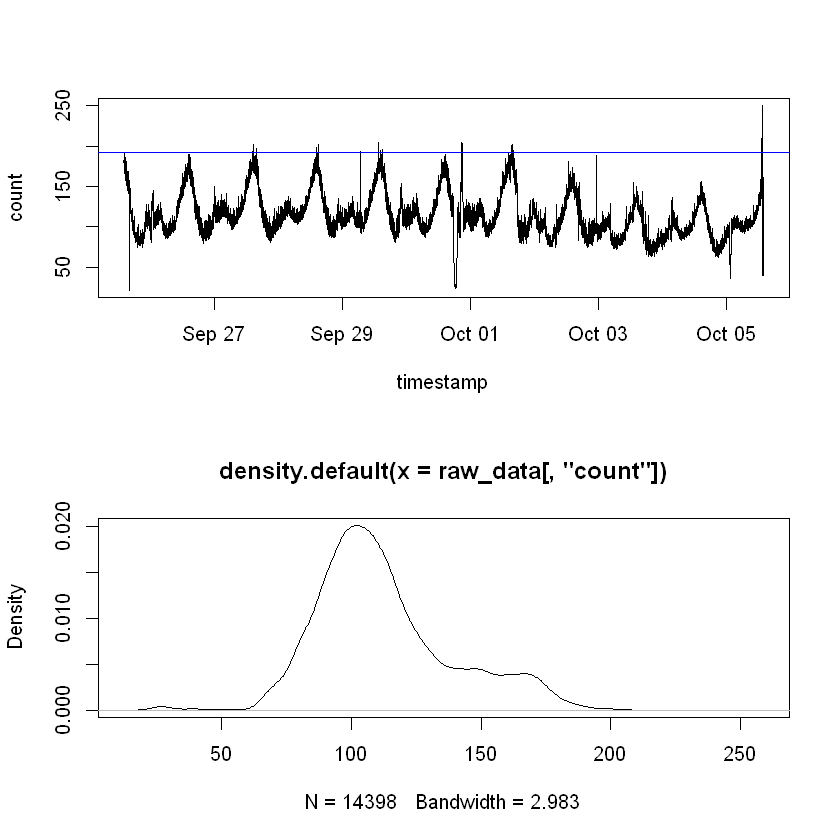

In [24]:
par(mfrow=c(2,1))
plot(raw_data,type='l')
abline(h=mean(raw_data[,'count'])+3*sd(raw_data[,'count']),col='blue')
#hist(raw_data[,'count'])
plot(density(raw_data[,'count']))

$3\sigma$ 규칙은 파란색 선($\mu+3\sigma$) 위를 global anomaly로 취급해 쉽게 찾음<br>
하지만 위 데이터처럼 계절성이 있을 때 local anomaly를 잘 못 찾음<br>
<br>
아래 그림은 데이터의 분포로 multimodal한 경향을 보임<br>
실제 데이터가 정확하게 Normal 분포 따르기가 어려움

In [25]:
ESD_data=ESD(raw_data[,2],0.05,8000,one_tail=FALSE,upper_tail=FALSE)

In [26]:
ESD_data

[1] 14368

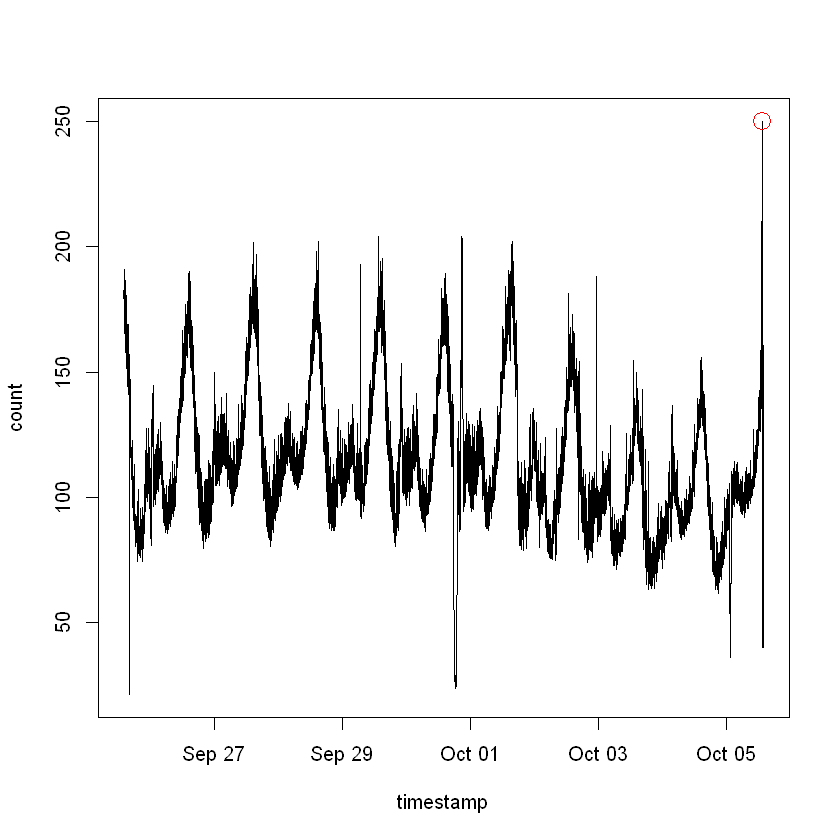

In [27]:
plot(raw_data,type='l')
points(raw_data[ESD_data,],col='red',cex=2)

데이터에 직접 ESD를 적용했을 때 anomaly를 하나 밖에 못 찾는 문제가 생김

# 3.2 Moving Averages

그렇다면 White noise를 모델링하는 것은 어떨까?<br>
가장 많이 쓰이는 Moving Averages 방법을 살펴보겠습니다.

Moving Average는 White noise의 영향을 줄이기 위해 사용 => white noise를 필터링(smooth하게 만들어 줌)

Simple Moving Average(SMA)<br>
$SMA_{t}=\frac{x_{t}+x_{t-1}+...+x_{t-(n-1)}}{n}$<br>
데이터마다 같은 가중치를 줌

In [28]:
SMA<-function(A,n){
    T<-length(A)
    mean(A[T:(T-n+1)])
    MEAN<-c(rep(NA,(n-1)))
    for (t in (n:T) ){
        MEAN<-c(MEAN,mean(A[t:(t-n+1)]))
        }
    
    return(MEAN)
        
}

Exponentially Weighted Moving Average (EWMA)<br>
$y_{t}=x_{t},  t=1$<br>
$y_{t}=\alpha x_{t} +(1-\alpha)y_{t-1}, t>1 $

SMA와는 다르게 전 시점의 정보와 다음 시점의 가중 평균으로 반영<br>
$\alpha$:현재 정보의 반영 비율<br>
높을 수록 현재 정보를 많이 반영하고 전 시점의 정보 조금 반영 

In [29]:
EWMA <- function (x, ratio) {
  c(filter(x * ratio, 1 - ratio, "recursive", init = x[1]))
}

시계열 데이터가 갑작스럽게 변하면 EWMA는 anomaly를 잡아내지 못함 

Probabilistic Exponentially Weighted Moving Average (PEWMA)<br>
EWMA에서 $\alpha=(1-P_{t})$<br>
$P_{t}$는 임의의 분포에서의 $x_{t}$의 확률을 측정<br>
가중치 파라미터 $\alpha$를 데이터에 적응적으로 조절함

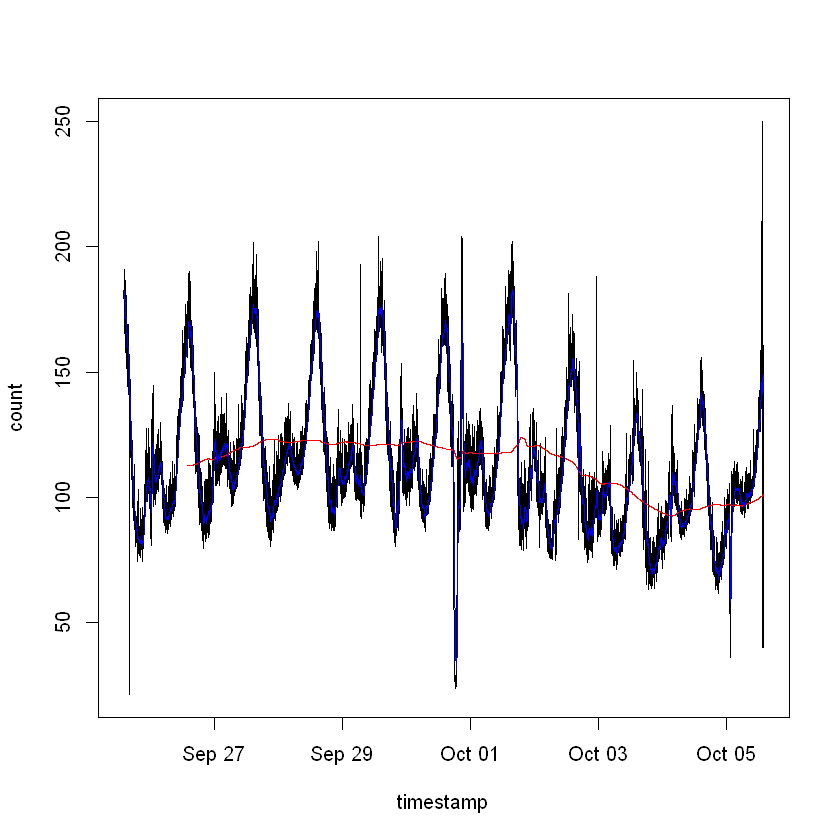

In [30]:
plot(raw_data,type='l')
lines(raw_data[,'timestamp'],SMA(raw_data[,'count'],1440),type='l',col='red')
lines(raw_data[,'timestamp'],EWMA(raw_data[,'count'],0.05),type='l',col='blue')

- SMA는 빨간 선으로 하루(1440분) 주기로 smoothing을 했을 때 smoothing을 너무 많이 해서 거의 직선에 가까워져 버려 계절성과 같은 패턴에 대한 정보를 잃어버렸습니다.
- EWMA는 파란선으로 $\alpha$를 0.05로 두어 최근 정보를 많이 반영하게 했지만 한 시점 정도 느리게 추세를 따라가는 경향이 있었습니다.

In [31]:
EWMA_error<-raw_data[,'count']-EWMA(raw_data[,'count'],0.01)

In [32]:
ESD_EWMA<-ESD(  EWMA_error ,0.05,7000,one_tail=FALSE,upper_tail=FALSE)

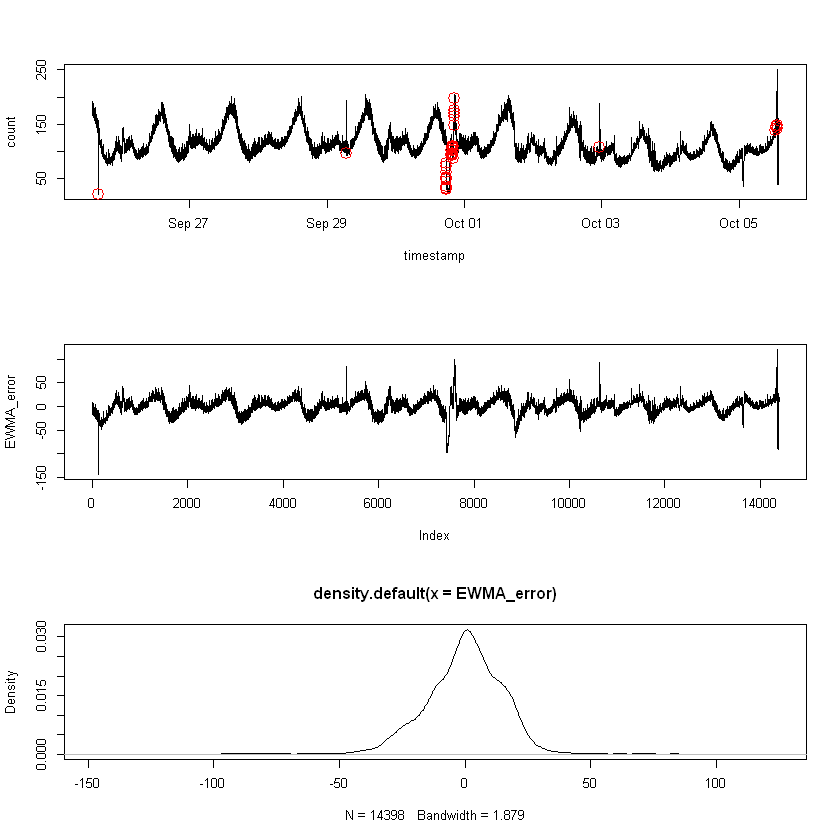

In [33]:
par(mfrow=c(3,1))
plot(raw_data,type='l')
points(raw_data[ESD_EWMA,],col='red',cex=2)
plot(EWMA_error,type='l')
plot(density(EWMA_error))

EWMA로 데이터의 트렌드를 제거하고 ESD를 적용했을 때 맨 우측의 Outlier를 탐지 못하고 특정 기간의 outlier를 집중적으로 포착했습니다 <br>
이것으로 보아 global anomaly와 seasonal anomaly 모두 포착하는데 문제가 있음을 알 수 있습니다.<br>
<br>
두 번째 그림은 Residual의 plot으로 여전히 계절성이 존재함을 알 수 있습니다.<br>
세 번째 그림은 residual의 plot으로 여전히 Normal 분포라고 보기 어려워 ESD를 적용하는게 타당한지에 대한 의문이 생깁니다.

이동 평균 방법은 대부분의 계절성을 가진 anomaly를 filter out 해버리는 문제점


# 3.3 Seasonality and STL

이제 계절성을 처리하기 위해 Seasonality를 고려할 수 있는 STL decomposition에 대해 살펴 보겠습니다.

먼저 데이터의 특성을 다시 살펴 보겠습니다.
- 데이터의 계절성이 뚜렷 <br>
- 데이터의 분포가 multimodal로 normal 하지 않음<br>
- 멀티 모달일 경우 표준편차가 높아져서 진짜 anomaly를 찾는데 방해함<br>
- Residual이 유니모달한 분포이면 ESD 같은 방법 활용 가능해짐<br>

X: 원래 시계열 데이터<br>
$S_{x}$:계절성<br>
$T_{x}$:트렌드<br>
$R_{x}$:Residual<br>
X를 $S_{x}$,$T_{x}$,$R_{x}$로 분해해 Residual을 찾음

전형적인 STL decompostion은 다음과 같습니다.<br>
$T_{x}$: moving average filter을 사용<br>
그후에 $X-T_{x}$로 트렌드 제거<br>
$S_{x}$은 sub-cycle의 평균으로 구하자 (sub-cycle은 예를 들어, 달마다, 연마다 계절성이 두 개 있으면 더 작은 달마다 계절성을 말함, 여기서는 하루마다)<br>
$R_{x}=X-T_{x}-S_{x}$

하지만 $T_{x}$에 단순한 moving average filter을 사용하면 Residual에 극단적인 anomaly가 있으면 제대로 작용하지 않습니다.<br>
따라서 LOESS를 사용한 로버스트 추정을 사용하여 계절성을 추정하였습니다.<br> 
LOESS는 decompostion 방법이 더 복잡한 함수에 적합할 수 있도록 하는 장점이 있습니다.

In [34]:
TS_data<-ts(raw_data[,'count'], frequency = 1440)
data_decomp <- stl(TS_data,s.window = "periodic", robust = TRUE)
S<-data_decomp$time.series[,1]

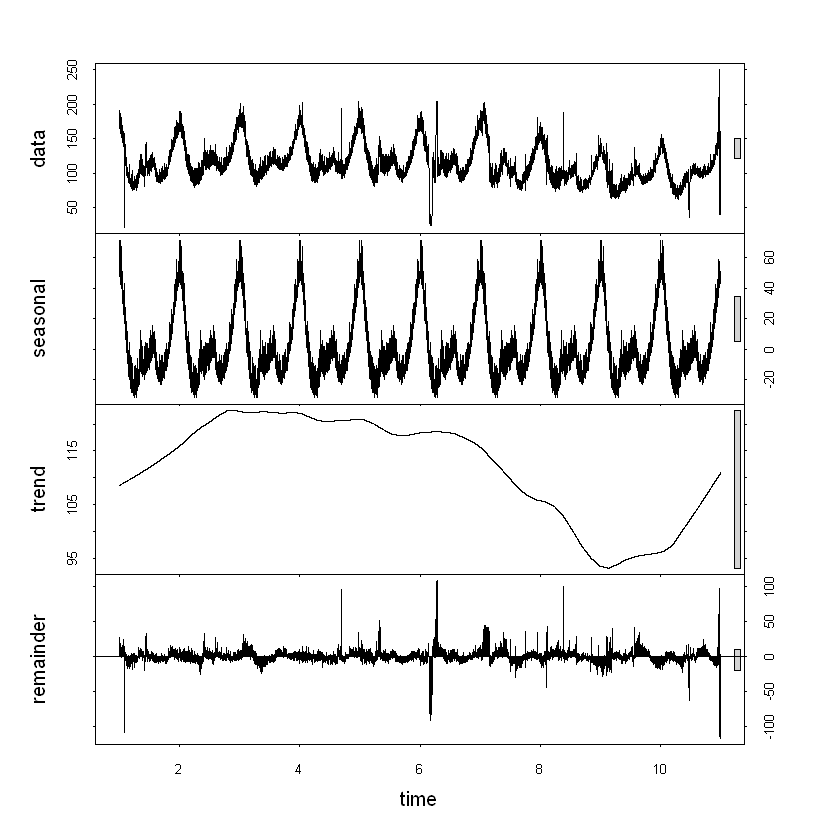

In [35]:
plot(data_decomp)

In [36]:
ESD_STL<-ESD(  data_decomp$time.series[,3] ,0.05,7000,one_tail=FALSE,upper_tail=FALSE)

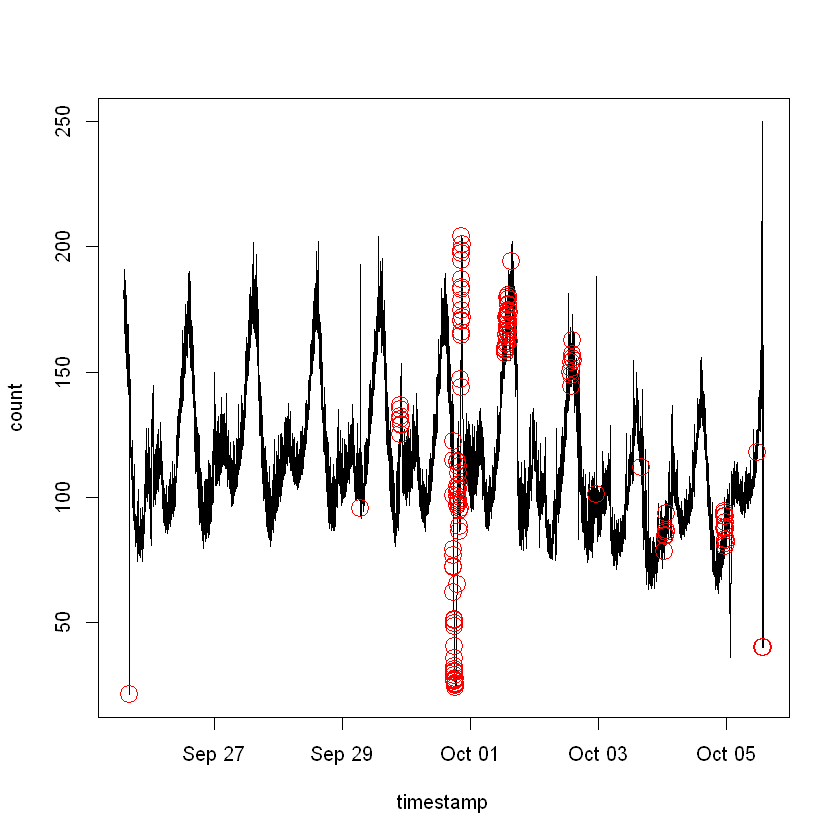

In [37]:
plot(raw_data,type='l')
points(raw_data[ESD_STL,],col='red',cex=2)

STL decompostion으로 하면 EWMA만을 사용했을 때보다 훨씬 많은 Anomaly를 찾아 냈음을 알 수 있지만 여전히 부족해 보입니다.<br>
또한 Anomaly가 아닌 것처럼 보이는데 잡아낸 것도 보이는 것 같습니다

# 3.4.1 STL Variants (S-ESD)

- STL decompostion으로 하면 Spurious anomaly를 만들 수 있다 (anomaly가 아닌데 anomlay로 착각)<br>
- 따라서 트렌드를 원래 데이터의 중위수로 두는 $\tilde{X}$ 이용하여 <br>
- $R_{x}=X-S_{x}-\tilde{X}$ 제안


- 이것은 계절성 $S_x$을 추정할 때 LOESS를 사용하여 계절성을 분해합니다.<br>
- 이후 안정적인 트렌드를 추출하기 위해 Medain을 사용하여 트렌드를 분해하는 것입니다.<br>
- Median을 이용하여 트렌드를 분해하면 Residual을 안정화 시켜 Spurious를 제거할 수 있습니다.

In [38]:
STL_VAR<-TS_data-S-median(TS_data)

In [39]:
ESD_STL_VAR<-ESD(  STL_VAR ,0.05,7000,one_tail=FALSE,upper_tail=FALSE)

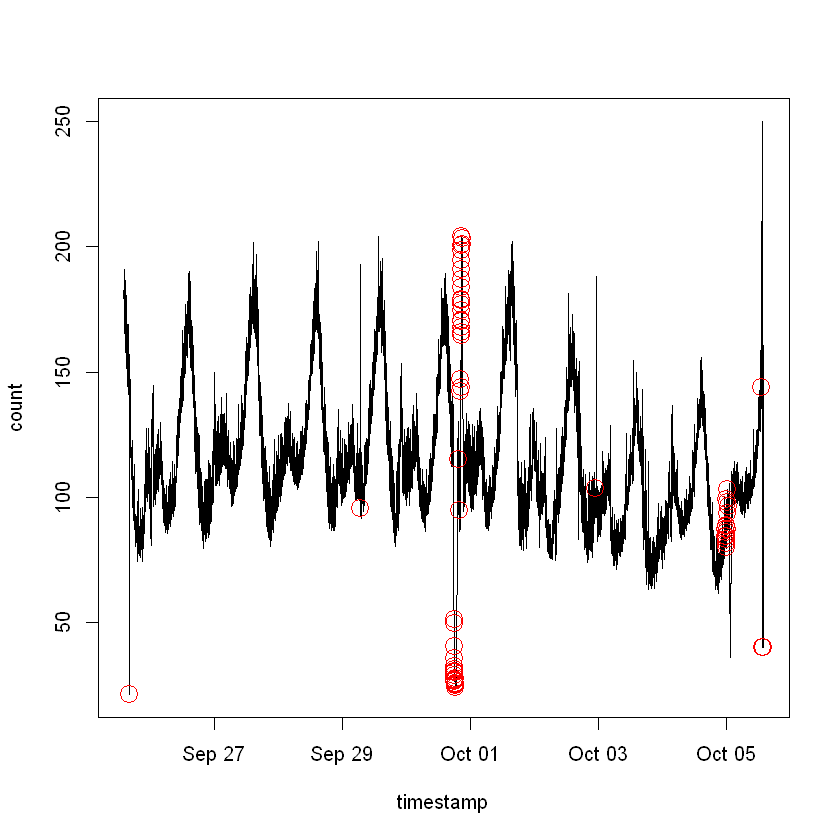

In [40]:
plot(raw_data,type='l')
points(raw_data[ESD_STL_VAR,],col='red',cex=2)

10월 4일 쯤에 STL로 anomaly라고 진단했던 것들이 사라졌습니다.<br>

- 하지만 S-ESD는 global anomaly와 local anomaly를 발견할 수 있지만 데이터에서 anomaly의 비율이 높으면 잘 작용을 안하는 문제가 있습니다.
- 그 이유는 ESD 검정 부분에서 평균과 표준편차를 사용하기 때문에 값이 큰 데이터가 평균과 분산을 과대 추정하게 만들기 때문입니다

# 3.5 Seasonal Hybrid ESD

Seasonal Hybrid ESD는 S-ESD의 측도에 2.2장과 같이 Medan을 사용하여 로버스트하게 만드는 방법입니다. 

In [41]:
data.frame(MEAN=mean(raw_data[,'count']),MEDIAN=median(raw_data[,'count']),SD=sd(raw_data[,'count']),MAD=mad(raw_data[,'count']))

MEAN,MEDIAN,SD,MAD
112.5469,107.435,26.51225,21.09265


데이터를 봤을 때 평균과 중위수는 5 정도 차이가 나고 표준편차와 MAD 또한 5정도 차이가 났습니다.

In [42]:
ESD_STL_HESD<-HESD(  STL_VAR ,0.05,7000,one_tail=FALSE,upper_tail=FALSE)

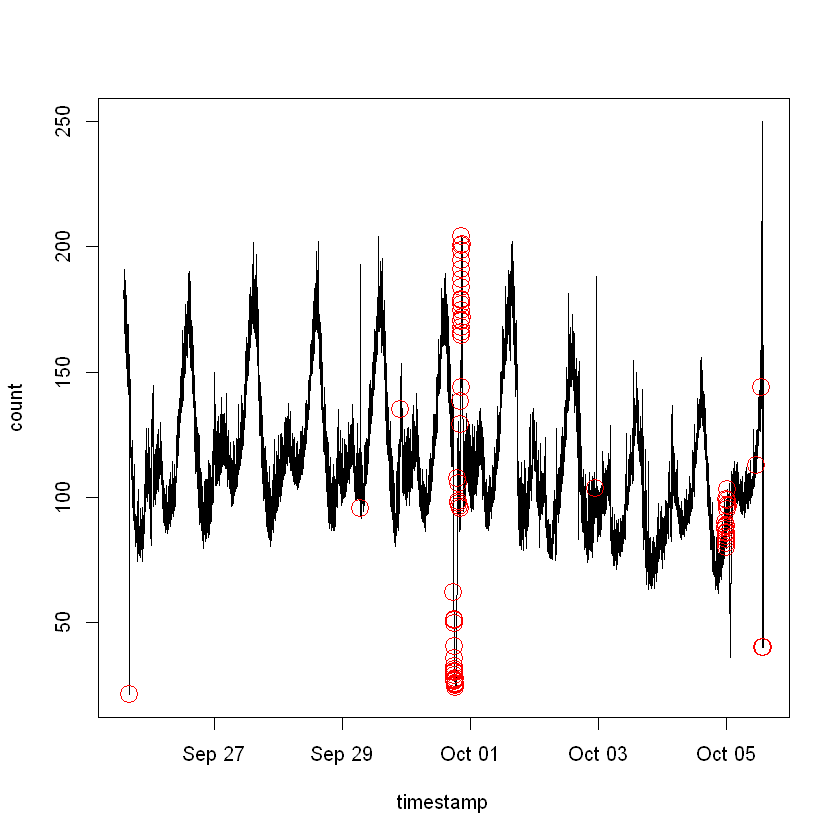

In [43]:
plot(raw_data,type='l')
points(raw_data[ESD_STL_HESD,],col='red',cex=2)

S-H-ESD에서 seasonal anomaly나 local anamaly를 훨씬 더 잘 탐지하는 것을 알 수 있습니다

# 평가

1) Capacity Engineering: 과부하된 데이터를 Precision, Recall, F-score로 평가<br>
2) User behavior: 서비스 제공자가 사용자 행동을 변화 시킬 수 있는 신호를 탐지하기 위해 데이터에서 관심 있는 부분에 임계치를 설정하고 그것을 넘었냐 안 넘었냐를 Precision, Recall, F-score로 평가<br>
3) Supervised Learning: anomaly인지 아닌지 일일히 레이블을 달기는 어렵기 때문에 데이터에 Smooth spline 적합해서 원래 데이터와 같은 성질의 트렌드와 계절성을 추출. 그후에 진짜 anomaly를 추출한 시계열 데이터에 넣어서 알고리즘이 그 진짜 anomaly를 얼마나 탐지하는지 측정